In [2]:
import os
import sys
import pandas as pd
sys.path.append('../')
from predictor.physicochemical import calculate_physchem_prop
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import joblib
from config import HEMO_SCORE_PIPELINE_PATH, MIC_SCORE_PIPELNE_PATH, AMP_SCORE_PIPELINE_PATH

In [5]:
df_dbaasp = pd.read_csv('../data/dbaasp/fine_tune_activity.csv')
df_dbaasp = df_dbaasp.query('activity == 1')
df_amp = pd.read_csv('../data/hydramp/unlabelled_positive.csv')
df_grampa = pd.read_csv('../data/grampa.csv')


df_dbaasp['db'] = 'dbaasp'
df_amp['db'] = 'amp'
df_grampa['db'] = 'grampa'

In [6]:
def regularize_sequence(df, seq_col='Sequence'):
    df[seq_col] = df[seq_col].apply(lambda x:x.upper())

    return df

In [7]:
def add_pc_to_df(df, seq_col='Sequence'):
    seqs = df[seq_col].to_list()
    pc_dict = calculate_physchem_prop(seqs)    
    for pc_name, pc_vals in pc_dict.items():
        df[pc_name] = pc_vals
    
    return df

In [8]:
df_dbaasp = regularize_sequence(df_dbaasp)

In [9]:
df_amp = add_pc_to_df(df_amp)
df_dbaasp = add_pc_to_df(df_dbaasp)
#df_grampa = add_pc_to_df(df_grampa, seq_col='sequence')

In [10]:
df_joined = pd.concat([
    df_amp,
    df_dbaasp
], axis=0)

In [11]:
pc_cols = ['length','hydrophobicity','hydrophobic_moment','charge','isoelectric_point']

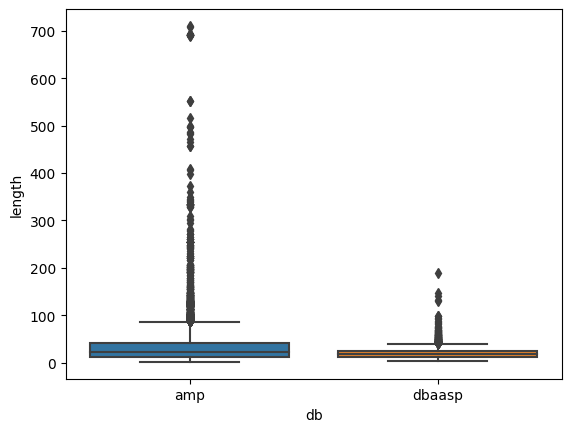

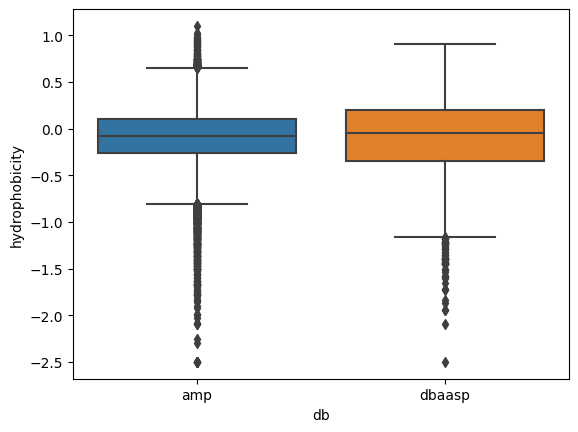

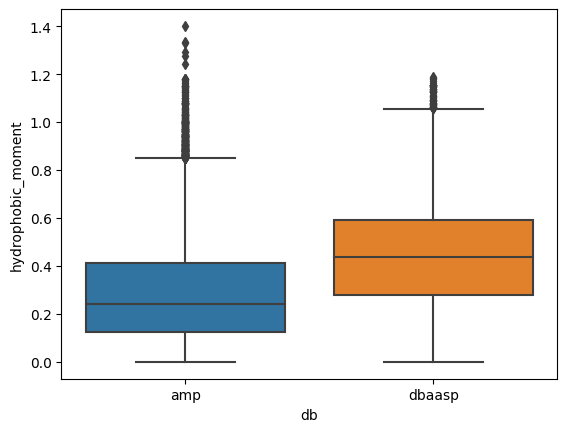

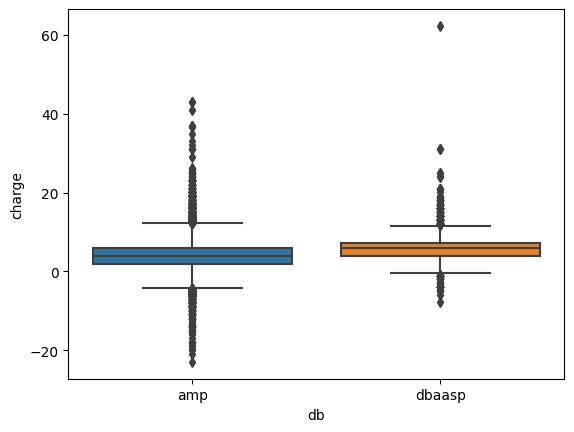

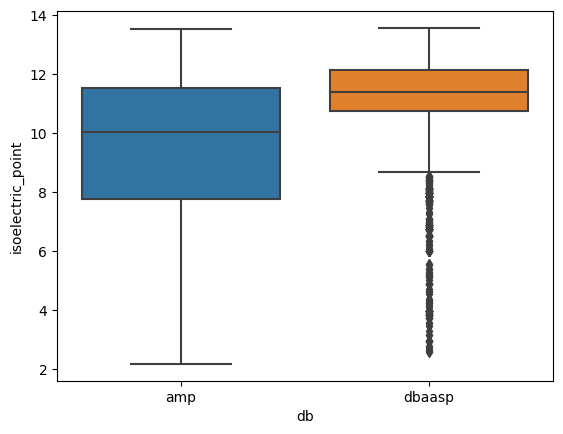

In [12]:
for pc_col in pc_cols:
    plt.figure()
    sns.boxplot(data=df_joined, x="db", y=pc_col)
    # break

In [13]:
df_joined.groupby('db')[pc_cols[0]].describe()    

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
amp,20313.0,33.342588,36.774125,2.0,12.0,23.0,42.0,710.0
dbaasp,4774.0,19.920612,10.500795,3.0,13.0,18.0,24.0,190.0


In [14]:
df_joined.groupby('db')[pc_cols[1]].describe()    

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
amp,20313.0,-0.097064,0.332121,-2.5,-0.258065,-0.074500,0.106667,1.1000
dbaasp,4774.0,-0.090353,0.401970,-2.5,-0.345000,-0.048824,0.196923,0.9025


In [15]:
df_joined.groupby('db')[pc_cols[2]].describe()    

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
amp,20313.0,0.291402,0.210223,5.242720e-17,0.124289,0.239702,0.414446,1.400997
dbaasp,4774.0,0.451417,0.228031,7.618362e-17,0.280315,0.436959,0.591116,1.187655


In [16]:
df_joined.groupby('db')[pc_cols[3]].describe()    

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
amp,20313.0,3.978476,4.153387,-22.971,1.861,3.9960,5.995,42.987
dbaasp,4774.0,5.859261,3.270847,-7.883,3.995,5.8605,7.094,62.286


### TODO
1. to score the dataset using score_pipline
2. to get the reference group data in HydrAMP (random, uniprot, positive, negative)

# Model Scoring

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class KMerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(self.extract_kmers(seq)) for seq in X]

    def extract_kmers(self, sequence):
        # if len(sequence) < self.k:
        #     return []
        return [sequence[i:i+self.k] for i in range(len(sequence) - self.k + 1)]

In [20]:
hemo_scorer = joblib.load(HEMO_SCORE_PIPELINE_PATH)
mic_scorer = joblib.load(MIC_SCORE_PIPELNE_PATH)
amp_scorer = joblib.load(AMP_SCORE_PIPELINE_PATH)

In [26]:
len(df_joined)

25087

In [29]:
df_joined['p_hemo'] = hemo_scorer.predict_proba(df_joined['Sequence'].to_numpy())[:,1]
df_joined['p_mic'] = mic_scorer.predict_proba(df_joined['Sequence'].to_numpy())[:,1]
df_joined['p_amp'] = amp_scorer.predict_proba(df_joined['Sequence'].to_numpy())[:,1]


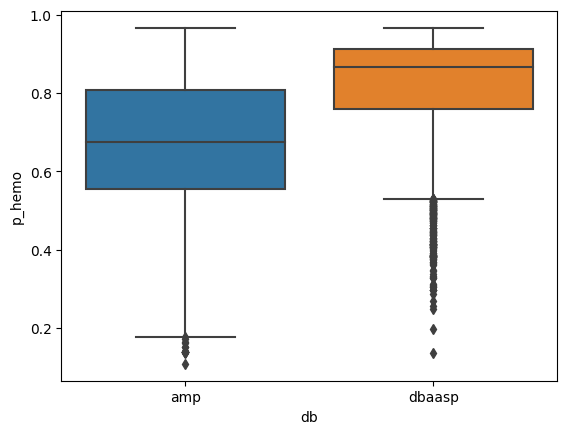

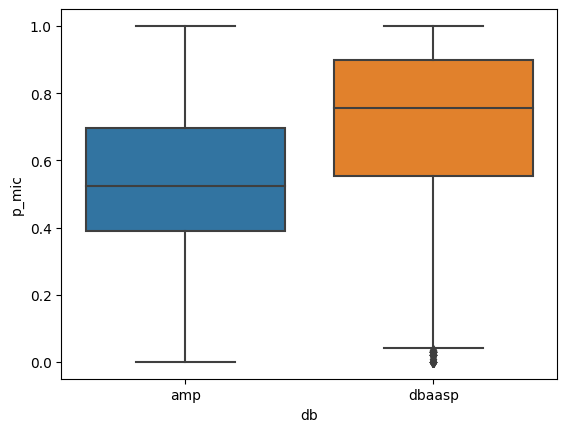

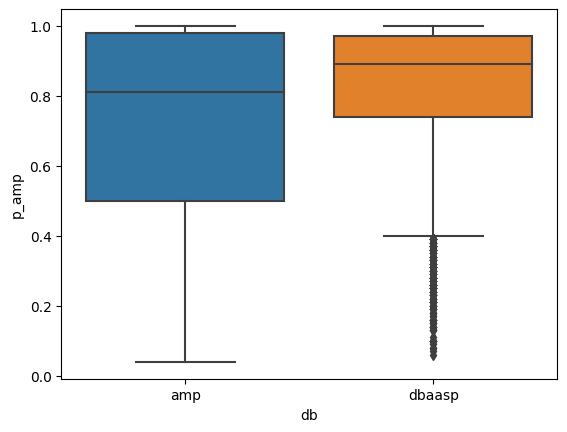

In [31]:
p_score_cols = ['p_hemo', 'p_mic', 'p_amp']
for p_col in p_score_cols:
    plt.figure()
    sns.boxplot(data=df_joined, x="db", y=p_col)